This file include the implementation of other methods for SGM-FC

1. eigenmapping

2. raw SC

# Import some pkgs

In [1]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict
from collections import defaultdict as ddict
from IPython.display import display
%load_ext autoreload
%autoreload 2

In [2]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [3]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch
from utils.measures import geodesic_dist, reg_R_fn, lin_R_fn, lap_mat_fn

plt.style.use(FIG_ROOT/"base.mplstyle")

# Some fns

In [4]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x));
_remove_norm = lambda x: x/np.linalg.norm(x)
_std_vec = lambda x: (x-np.mean(x))/np.std(x)
_remove_scale = _minmax_vec
uptri_idxs = np.triu_indices(68, k=1);
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [5]:
def _get_base_metrics(fc, num_rep=1000):
    """Get baseline mse via random shuffling.
    """
    def _mse_err(ele1, ele2):
        fc1_c = _remove_scale(ele1)
        fc2_c = _remove_scale(ele2)
        return np.mean((fc1_c-fc2_c)**2)
    
    idxs = np.triu_indices_from(fc, k=1)
    eles = fc[idxs]
    eles_mm = _remove_scale(eles)
    
    metrics = edict()
    mses = []
    linrs = []
    for ix in range(num_rep):
        rand_eles_mm = np.random.permutation(eles_mm)
        mses.append(np.mean((rand_eles_mm-eles_mm)**2))
        linrs.append(lin_R_fn(rand_eles_mm.reshape(1, -1), 
                              eles_mm.reshape(1, -1))[0])
    metrics.mse = [np.mean(mses), np.std(mses)]
    metrics.linr = [np.mean(linrs), np.std(linrs)]
    return metrics

In [6]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr

def divide_fc(fc):
    """Divide the FC into three blocks and vectorize them
    """
    size_fc = len(fc)
    hs_fc = int(size_fc/2)
    fc_block1 = fc[:hs_fc, :hs_fc]
    fc_block2 = fc[hs_fc:, hs_fc:];
    fc_block3 = fc[:hs_fc, hs_fc:];
    vec1 = _remove_scale(fc_block1[np.triu_indices(hs_fc, k = 1)])
    vec2 = _remove_scale(fc_block2[np.triu_indices(hs_fc, k = 1)])
    vec3 = _remove_scale(fc_block3.flatten())
    return vec1, vec2, vec3

def cal_metrics(fc1, fc2):
    """Calculate the distance between fc1 and fc2, including
        1. geodesic dist
        2. pearson's R
        3. lin R
        4. pearson's R after divide the FC into three blocks
        5. lin R after divide the FC into three blocks
    """
    fc1 = fc1.astype(np.float64)
    fc2 = fc2.astype(np.float64)
    size_fc = len(fc1)
    
    fc1_c = _remove_scale(fc1[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    fc2_c = _remove_scale(fc2[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    
    # for geodedic
    #fc1_g = fc1/np.linalg.norm(fc1) + np.eye(size_fc)
    #fc2_g = fc2/np.linalg.norm(fc2) + np.eye(size_fc)
    #fc1_g = lap_mat_fn(_vec_2mat(fc1_c)) # I think the geodesic dist should be based on results after minmax
    #fc2_g = lap_mat_fn(_vec_2mat(fc2_c))
    fc1_g = _vec_2mat(fc1_c.reshape(-1)) + np.eye(size_fc)
    fc2_g = _vec_2mat(fc2_c.reshape(-1)) + np.eye(size_fc)
    
    
    # all metrics
    geo_dist = geodesic_dist(fc1_g, fc2_g)
    reg_r = reg_R_fn(fc1_c, fc2_c)
    lin_r = lin_R_fn(fc1_c, fc2_c)
    mse = np.mean((fc1_c-fc2_c)**2)
    tau_r = kendalltau(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    sp_r = spearmanr(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    
    # block wise metrics
    blocks1 = divide_fc(fc1)
    blocks2 = divide_fc(fc2)
    reg_r_block = [reg_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    lin_r_block = [lin_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    
    res = edict()
    res.geo_dist = geo_dist
    res.reg_r = reg_r[0]
    res.lin_r = lin_r[0]
    res.tau_r = tau_r
    res.sp_r = sp_r 
    res.mse = mse
    res.reg_r_block = np.mean(reg_r_block)
    res.lin_r_block = np.mean(lin_r_block)
    return res

def cal_metrics_batch(fc1s, fc2s):
    """fc1s, fc2s: num_fc x 68 x 68
    """
    ress = ddict(list)
    for ix in range(len(fc1s)):
        fc_t = fc2s[ix]
        fc_e = fc1s[ix]
        res = cal_metrics(fc_t, fc_e)
        for key, v in res.items():
            ress[key].append(v)
    
    return ress

In [7]:
## both are not used (on Sep 8, 2023)
#def _preprocess_sc(sc):
#    sc = sc.copy()
#    max_v = np.quantile(sc, 0.99);
#    sc[sc>max_v] = max_v
#    #sc[sc <= 0.01*max_v] = 0
#    return sc
#def _preprocess_fc(fc):
#    fc = fc.copy()
#    #fc[fc<=0.2*fc.max()] = 0
#    return fc
#

# Load data and params

In [8]:
bds = ["delta", "theta", "alpha", "beta_l"]
bds = ["alpha"]

['alpha']

In [9]:
# em FC
fc_root = RES_ROOT/"emp_fcs2"
def _get_fc(sub_ix, bd):
    fil = list(fc_root.rglob(f"*{bd}*100/sub{sub_ix}.pkl"))[0]
    return np.abs(load_pkl(fil, verbose=False))

In [10]:
# fc from NMM
def _get_nmm_fc(sub_ix, bd):
    nmm_fc_root = RES_ROOT/f"NMM_{bd}_results"
    fil = list(nmm_fc_root.glob(f"best_fc{sub_ix}.pkl"))[0]
    return np.abs(load_pkl(fil, verbose=False))

In [11]:
# fc from ANN
def _get_ann_fc(sub_ix, bd):
    fc_root = RES_ROOT/f"rawfc2ep100_ANN_{bd}_addv1"
    fil = list(fc_root.glob(f"ind{sub_ix}.pkl"))[0]
    return np.abs(load_pkl(fil, verbose=False).bestfc[:68, :68])


In [12]:

def _add_v2con(cur_ind_conn):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.quantile(cur_ind_conn, 0.99)*0.01 # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn


In [13]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;
#scs = ind_conn.transpose(2, 0, 1)[:, :68, :68];
#scs = np.array([_preprocess_sc(sc) for sc in scs]);

scs = []
for cur_ind_idx in range(36):
    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  ind_conn[:, :, cur_ind_idx] # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    sc = brain.reducedConnectome
    sc = _add_v2con(sc)
    #sc = ind_conn[:, :, cur_ind_idx]
    scs.append(sc[:68, :68])
scs = np.array(scs)
scs.shape

(36, 68, 68)

In [14]:
base_mses = ddict(list)
base_linrs = ddict(list)
for band in bds:
    for sub_ix in trange(36, desc=f"{band}"):
        metrics = _get_base_metrics(_get_fc(sub_ix, band)) 
        base_mses[band].append(metrics.mse)
        base_linrs[band].append(metrics.linr)

alpha: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  8.80it/s]


# Eigenmapping

In [15]:
from scipy.optimize import minimize
class EigMapping():
    """Do eigenmapping approx from SC to FC.
    """
    def __init__(self, sc, init_ps, rescale_fn=lambda x: x):
        """args:
            sc: the SC matrix
            init_ps: Initial guess of the parameters, a list of two
            rescale_fn: The fn for rescale fc, default is the identity, minmax does not converge.
        """
        
        self.init_ps = init_ps
        self.eigvals, self.eigvecs = self._get_eigres(sc)
        self.rescale_fn = rescale_fn
        self.opt_ps = None
         
    def _get_eigres(self, sc):
        eigvals, eigvecs = np.linalg.eig(sc);
        sort_idxs = np.argsort(-np.abs(eigvals))
        eigvals, eigvecs = eigvals[sort_idxs], eigvecs[:, sort_idxs]
        return eigvals, eigvecs
        
    def _recon_fc(self, ps=None):
        p1, p2 = ps
        new_eigvals = np.exp(-p1*self.eigvals/np.median(self.eigvals))+p2
        rec_fc = self.eigvecs @ np.diag(new_eigvals) @ self.eigvecs.T
        return rec_fc - np.diag(np.diag(rec_fc))
    
    def opt(self, fc):
        def fun(ps):
            newfc = self._recon_fc(ps)
            idxs = np.triu_indices_from(newfc, k=1)
            return np.mean((self.rescale_fn(fc[idxs])-
                            self.rescale_fn(newfc[idxs]))**2)
        res = minimize(fun, self.init_ps, bounds= ((0, 1000), (-1000, 1000)), 
                      options=dict(disp=False))
        self.opt_ps = res.x
        if not res.success:
            print(f"May not converge, {res.message}.")
            
    def get_optfc(self, fc):
        if self.opt_ps is None:
            self.opt(fc)
        return self._recon_fc(self.opt_ps)

In [16]:
estfcs_eig = edict()
band = "delta"
for band in bds:
    tmp= []
    for sub_ix in trange(scs.shape[0], desc=f"{band}"):
        opt = EigMapping(scs[sub_ix], [0, 0]) 
        curfc = _get_fc(sub_ix, band)
        tmp.append(opt.get_optfc(curfc));
    estfcs_eig[band] = np.array(tmp)

alpha: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 24.16it/s]


# Compare all three methods

In [22]:
def _get_metric_std(df, base_mse, base_linr):
    base_mse = np.array(base_mse)
    base_linr = np.array(base_linr)
    df["mse_std"] = (df["mse"] - base_mse[:, 0])/base_mse[:, 1]
    df["lin_r_std"] = (df["lin_r"] - base_linr[:, 0])/base_linr[:, 1]
    return df

key_names = ['mse', "mse_std", 'lin_r', 'lin_r_std', 'geo_dist',  'reg_r']
#key_names = ['mse', "mse_std", 'lin_r', 'lin_r_std', 'geo_dist', 
#             'reg_r', 'tau_r', 'sp_r', 'reg_r_block', "lin_r_block"]
for band in bds:
    my_res = load_pkl(RES_ROOT/f"rawfc2ep100_posteriorMRmul_{band}_num1000_"
                               f"densitynsf_MR4_noise_sd40_addv1/inf_res_fb.pkl", 
                   verbose=False);
    estfcs = np.array([est_FC for est_FC in my_res.est_FCs]);
    empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    
    my_res = pd.DataFrame(cal_metrics_batch(estfcs, empfcs));
    eig_res = pd.DataFrame(cal_metrics_batch(estfcs_eig[band], empfcs))
    sc_res = pd.DataFrame(cal_metrics_batch(scs, empfcs));
    
    my_res = _get_metric_std(my_res, base_mses[band], base_linrs[band])
    eig_res = _get_metric_std(eig_res, base_mses[band], base_linrs[band])
    sc_res = _get_metric_std(sc_res, base_mses[band], base_linrs[band])
    out_df = pd.DataFrame(
            {
                "SGM": my_res.mean()[key_names],
                "Eig": eig_res.mean()[key_names],
                "SC": sc_res.mean()[key_names], 
            }
        ).T
    print(f"Results of {band}")
    display(out_df)

Results of alpha


,mse,mse_std,lin_r,lin_r_std,geo_dist,reg_r
SGM,0.054775,-20.756269,0.253625,12.207798,18.469871,0.284117
Eig,0.066192,-15.151915,0.324276,15.607008,17.230945,0.419054
SC,0.088551,-3.968723,0.318969,15.354239,18.487931,0.429463


# Check

In [43]:
band = "alpha"
my_res = load_pkl(RES_ROOT/f"rawfc2ep100_posteriorMRmul_{band}_num1000_"
                           f"densitynsf_MR3_noise_sd20_addv1/inf_res_fb.pkl",  verbose=False);
estfcs = np.array(my_res.est_FCs);
empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
nmmfcs = np.array([_get_nmm_fc(sub_ix, band) for sub_ix in range(36)]);

In [44]:
fc0 = empfcs[0]
fc1 = estfcs[0]
fc2 = nmmfcs[0]
sc = scs[0];

vec0 =  _remove_scale(fc0[uptri_idxs])
vec1 =  _remove_scale(fc1[uptri_idxs])
vec2 =  _remove_scale(fc2[uptri_idxs])
vecsc =  _remove_scale(sc[uptri_idxs]);

In [92]:
def _tmp(vec):
    print(np.median(vec), np.std(vec))

In [93]:
_tmp(vec0), _tmp(vec1),_tmp(vecsc)

0.158861729468861 0.21162777980069344
0.13239707 0.12834057
0.0021622301630701297 0.21638103821338714


(None, None, None)

In [48]:
lin_R_fn(vec0, vec1), lin_R_fn(vec0, vecsc)

(array([0.29677126]), array([0.39911743]))

In [49]:
reg_R_fn(vec0, vec1), reg_R_fn(vec0, vecsc)

(array([0.35575356]), array([0.49479403]))

In [89]:
min_idxs = np.argsort(vec0)
vs = []
nums = []
for num in range(100, len(vec0), 100):
    nums.append(num)
    sel_idxs = min_idxs[-num:]
    v1, v2 = lin_R_fn(vec0[sel_idxs], vec1[sel_idxs]), lin_R_fn(vec0[sel_idxs], vecsc[sel_idxs])
    vs.append((v1[0], v2[0]))
vs = np.array(vs);

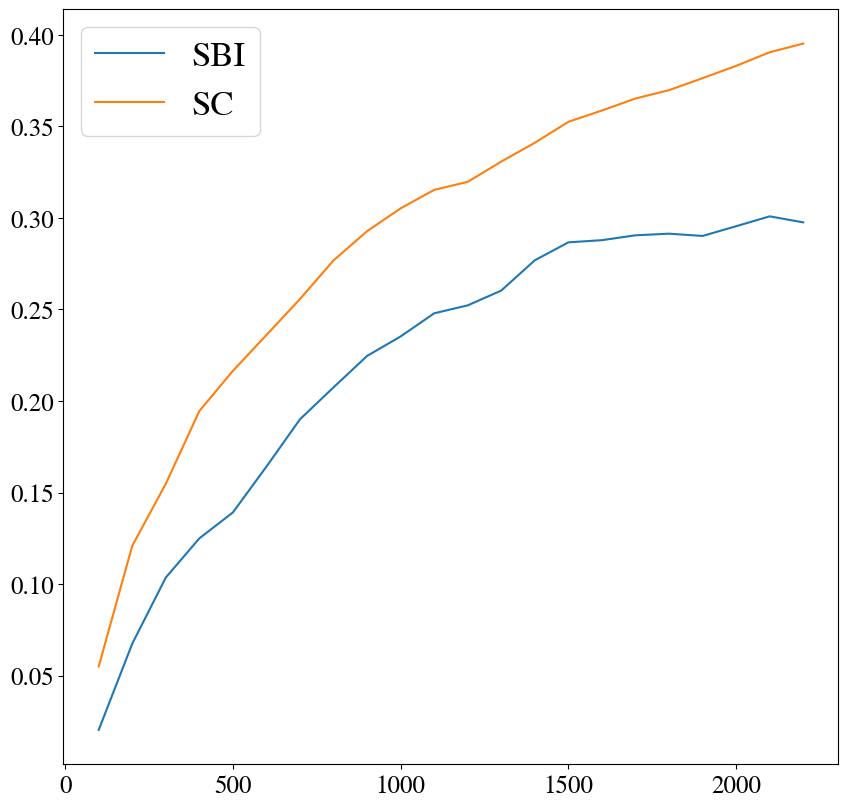

In [90]:
plt.plot(nums, vs[:, 0], label="SBI")
plt.plot(nums, vs[:, 1], label="SC")
plt.legend()

# Draw violin plot (not used)

In [10]:
bds = ["delta", "theta", "alpha", "beta_l"]
ress = []
for bd in bds:
    fcs = np.array([_get_fc(sub_ix, bd) for sub_ix in range(36)]);
    #fcs = np.array([_preprocess_fc(_get_fc(sub_ix, bd)) for sub_ix in range(36)]);
    res = cal_metrics_batch(fcs, scs);
    ress.append(res)

In [11]:
data = []
key_names = ['geo_dist', 'reg_r', 'tau_r', 'sp_r', 'lin_r', 'mse', 'reg_r_block', "lin_r_block"]
for ix in range(len(bds)):
    for key in key_names:
        for value in ress[ix][key]:
            data.append({'Band': bds[ix], 'Key': key, 'Value': value})
df = pd.DataFrame(data);

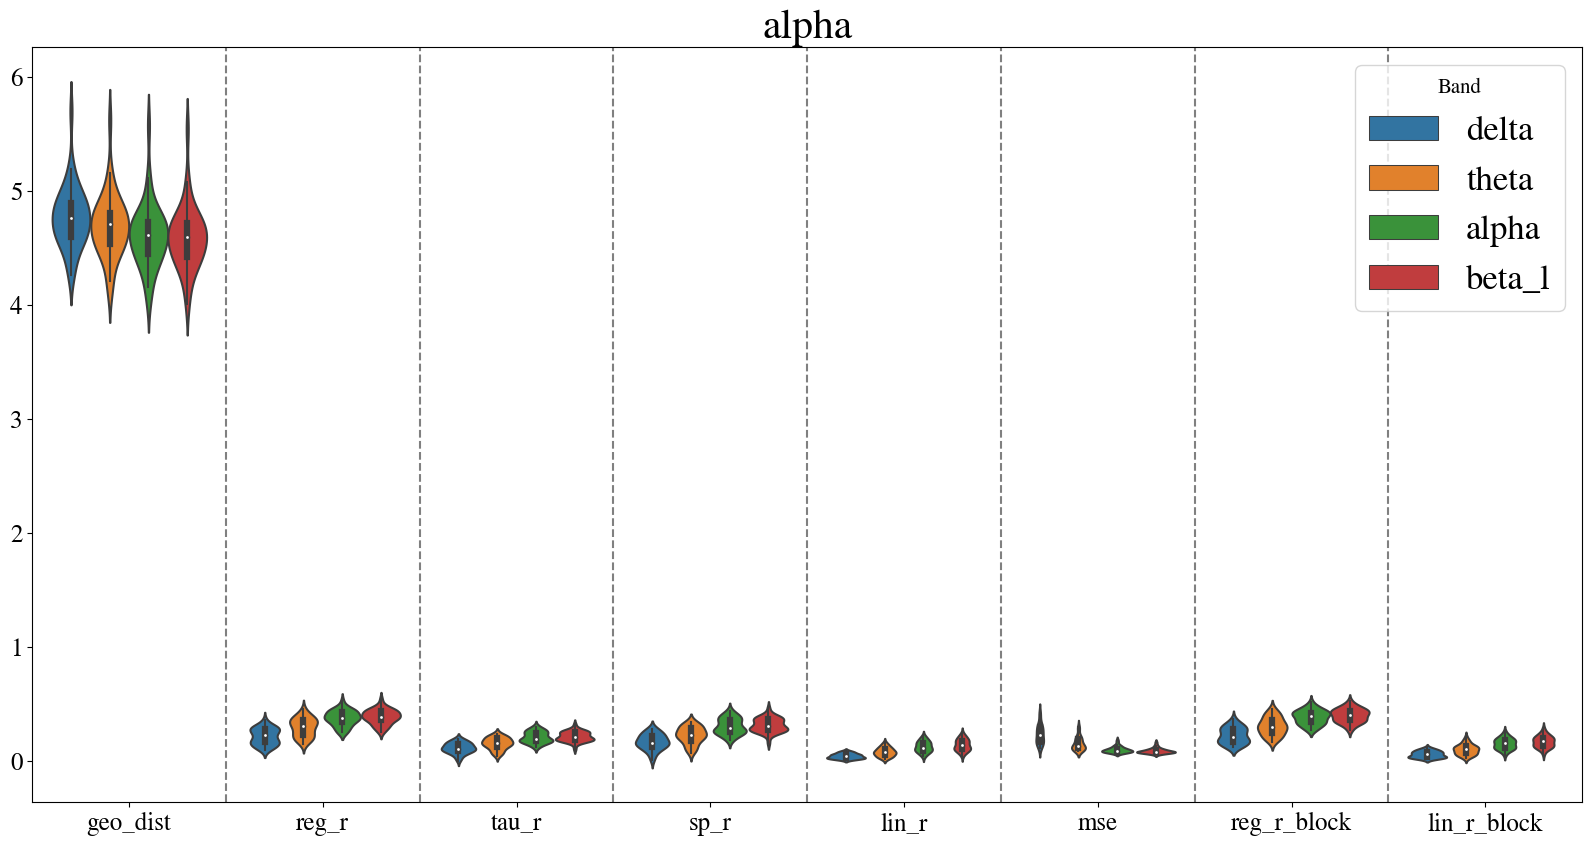

In [12]:
plt.figure(figsize=[20, 10])
plt.title(f"alpha", fontsize=30)
ax = sns.violinplot(x='Key', y='Value', hue='Band', data=df, split=False)
plt.xlabel("")
plt.ylabel("")

keys = df['Key'].unique()
for key_idx, key in enumerate(keys):
    if key_idx < len(keys) - 1:
        ax.axvline(x=key_idx + 0.5, color='grey', linestyle='--')
        
#plt.savefig(FIG_ROOT/f"{typ}_cmp.jpg")


In [13]:
from IPython.display import display
res_dict = {}
for ix in range(len(bds)):
    res = ress[ix]
    res_df = pd.DataFrame(res)
    res_dict[bds[ix]] = res_df.mean()
display(pd.DataFrame(res_dict))

,delta,theta,alpha,beta_l
geo_dist,4.766488,4.692101,4.606478,4.588435
reg_r,0.212883,0.293505,0.373770,0.385253
lin_r,0.040660,0.076625,0.123253,0.138048
tau_r,0.111218,0.150821,0.205604,0.212468
sp_r,0.165402,0.223066,0.302501,0.312134
mse,0.231275,0.149000,0.096527,0.085974
reg_r_block,0.221409,0.301520,0.381692,0.396712
lin_r_block,0.055886,0.097920,0.149381,0.166758
